A notebook to run the data from the March 2024 flights through NF2FF, without having to reinterpolate as before

In [1]:
## import statements:

import pandas,sys
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import *
from matplotlib.colors import LogNorm
from numpy.fft import fft2
from numpy.fft import ifft2
from numpy.fft import fftshift
from numpy.fft import ifftshift
from scipy.interpolate import griddata
from scipy.interpolate import RectBivariateSpline
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

sys.path.insert(0, '../classes/')
import NF2FFfuncs as nf

font = {'family' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

In [ ]:
# Still to understand:
## How to get beam from Etheta, Ephi
## if the beam extent makes sense

In [2]:
dat=np.load("/hirax/NF2FF/cplxEfield_20250611.npz")
for key in dat.keys():
    print(key)

cplxEfieldNS
cplxEfieldEW
dx
dy
freq


In [30]:
EW_Complex=dat['cplxEfieldEW']
NS_Complex=dat['cplxEfieldNS']
x = dat['dx']
y = dat['dy']
freq = dat['freq']
wl = 3E8/(freq*1E6)

print(EW_Complex.shape)
print(NS_Complex.shape)
print(x.shape)
print(y.shape)
print(freq)

(54, 54)
(54, 54)
(54, 54)
(54, 54)
670.703125


<ipython-input-4-126790ec187a>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0][0].pcolormesh(x,y,np.abs(EW_Complex))
<ipython-input-4-126790ec187a>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0][1].pcolormesh(x,y,np.abs(NS_Complex))
<ipython-input-4-126790ec187a>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or 

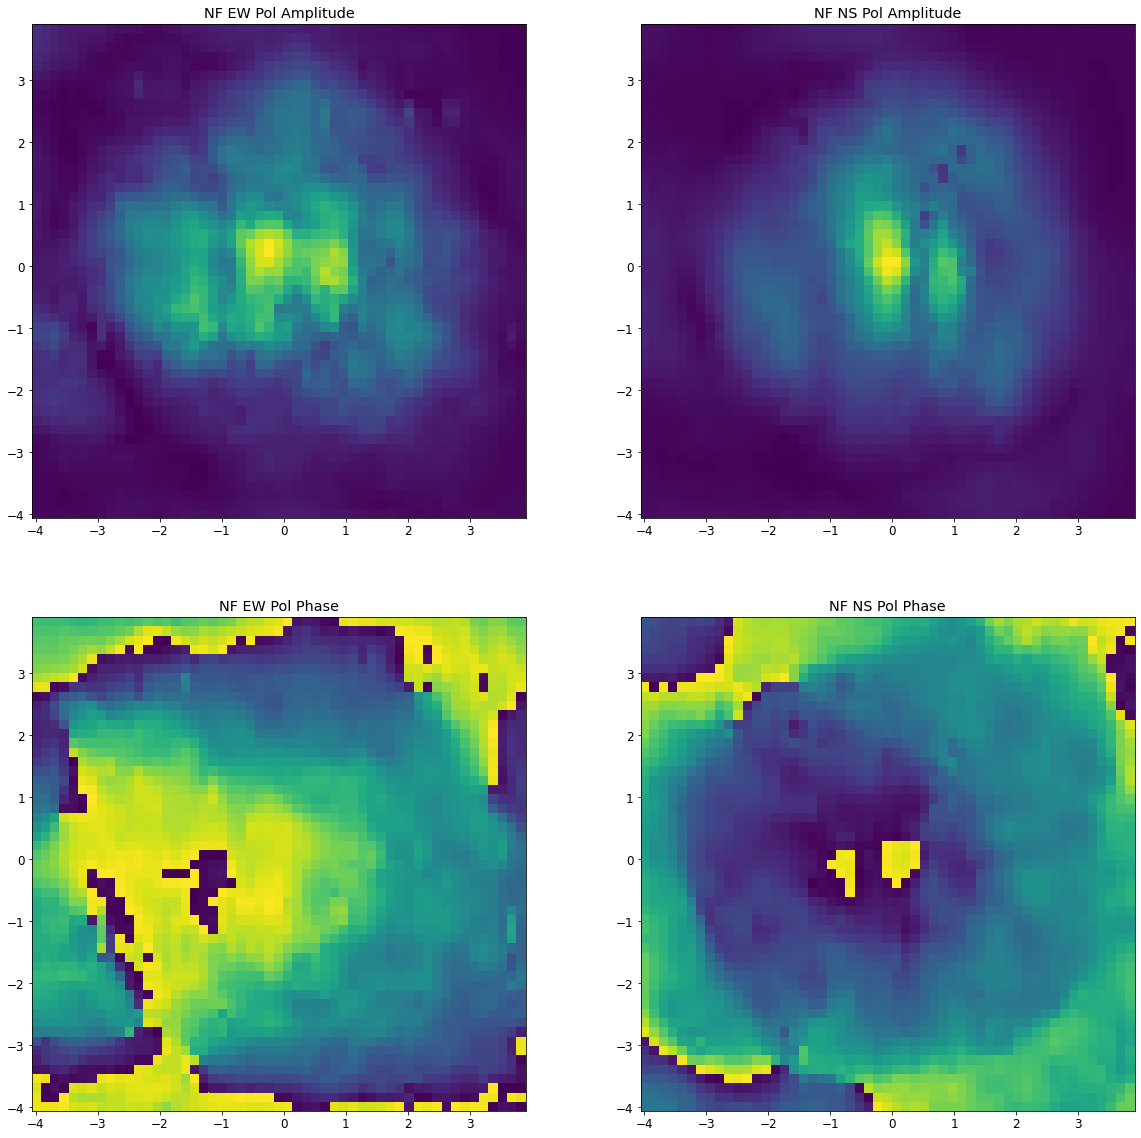

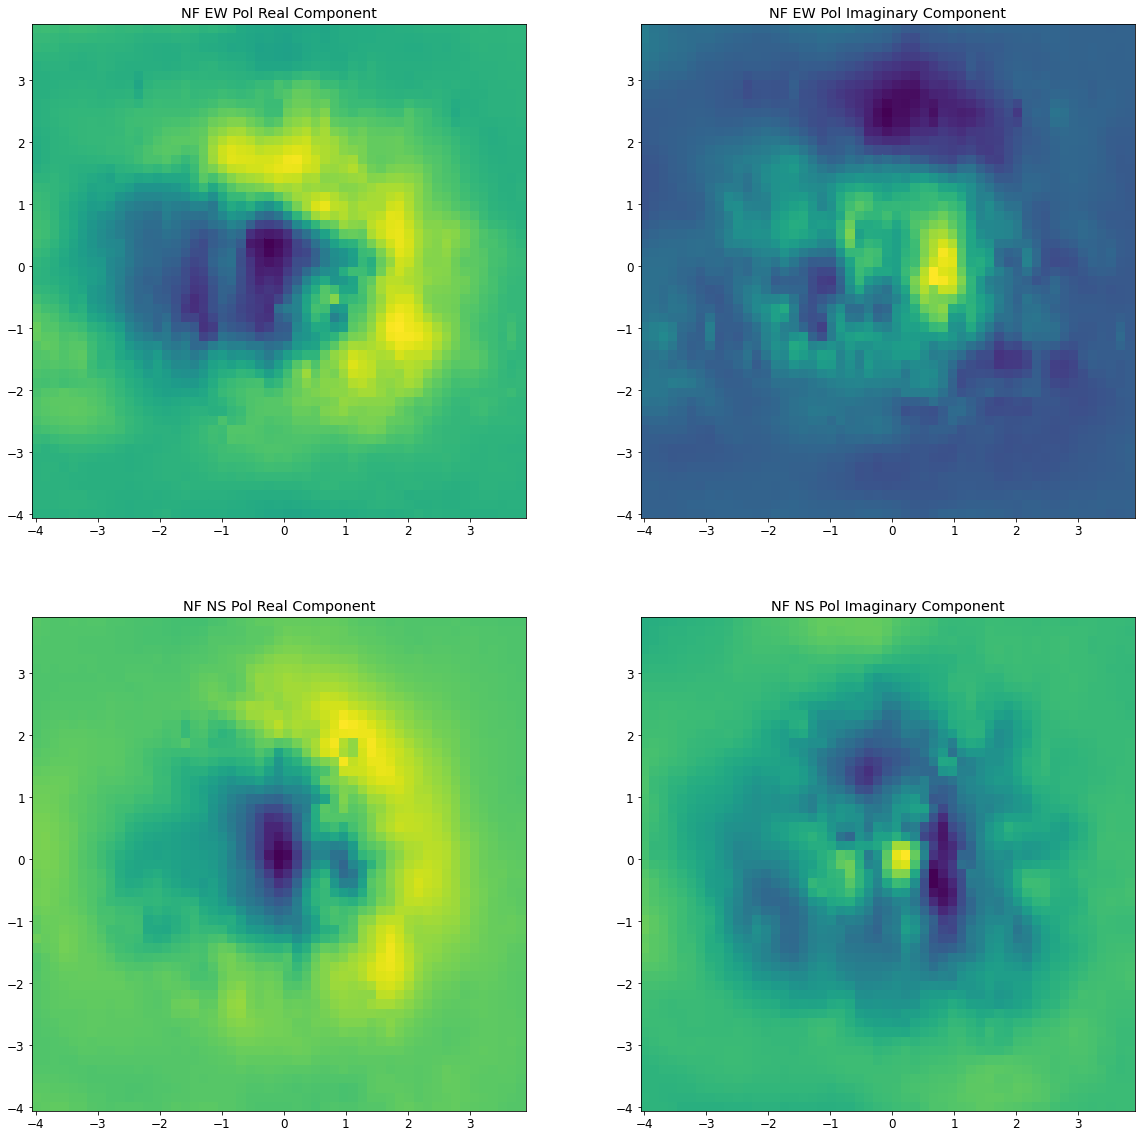

In [4]:
## Plot the complex fields in various ways to make sure they exist ok
fig,ax=subplots(2,2,figsize=(20,20))
ax[0][0].pcolormesh(x,y,np.abs(EW_Complex))
ax[0][0].set_title('NF EW Pol Amplitude')
ax[0][1].pcolormesh(x,y,np.abs(NS_Complex))
ax[0][1].set_title('NF NS Pol Amplitude')
ax[1][0].pcolormesh(x,y,np.angle(EW_Complex))
ax[1][0].set_title('NF EW Pol Phase')
ax[1][1].pcolormesh(x,y,np.angle(NS_Complex))
ax[1][1].set_title('NF NS Pol Phase')
for axis_set in ax:
    for a in axis_set:
        a.set_aspect('equal')

        
fig,ax=subplots(2,2,figsize=(20,20))
ax[0][0].pcolormesh(x,y,(EW_Complex.real))
ax[0][0].set_title('NF EW Pol Real Component')
ax[0][1].pcolormesh(x,y,(EW_Complex.imag))
ax[0][1].set_title('NF EW Pol Imaginary Component')
ax[1][0].pcolormesh(x,y,(NS_Complex.real))
ax[1][0].set_title('NF NS Pol Real Component')
ax[1][1].pcolormesh(x,y,(NS_Complex.imag))
ax[1][1].set_title('NF NS Pol Imaginary Component')
for axis_set in ax:
    for a in axis_set:
        a.set_aspect('equal')

In [5]:
# Check spacing and things

x_vector = x[:,0]
y_vector = y[0,:]

print(x_vector)
print(y_vector)

# making the k-space gridding

M=EW_Complex.shape[0]
N=EW_Complex.shape[1]
dx = x_vector[1] - x_vector[0]
dy = y_vector[1] - y_vector[0]


# setting up k-space, theta, phi grids
# See equations (16-13a) and (16-13b) in Balanis
# Zero padding is used to increase the resolution of the plane wave spectral domain.
MI=4*M
NI=4*N
m=np.linspace(-MI/2,MI/2-1,MI)
n=np.linspace(-NI/2,NI/2-1,NI)
k_X_Rectangular=(2*np.pi*m)/(MI*dx)
k_Y_Rectangular=(2*np.pi*n)/(NI*dy)

dtheta = 0.01 # before was at 0.05
dphi = 0.01
theta=np.arange(0,np.pi/2+dtheta,dtheta)
phi=np.arange(0,2*np.pi+dphi,dphi)
[theta,phi]=np.meshgrid(theta,phi)

print(theta)
print(phi)

[-4.06033835e+00 -3.90996241e+00 -3.75958647e+00 -3.60921053e+00
 -3.45883459e+00 -3.30845865e+00 -3.15808271e+00 -3.00770677e+00
 -2.85733083e+00 -2.70695489e+00 -2.55657895e+00 -2.40620301e+00
 -2.25582707e+00 -2.10545113e+00 -1.95507519e+00 -1.80469925e+00
 -1.65432331e+00 -1.50394737e+00 -1.35357143e+00 -1.20319549e+00
 -1.05281955e+00 -9.02443609e-01 -7.52067669e-01 -6.01691729e-01
 -4.51315789e-01 -3.00939850e-01 -1.50563910e-01 -1.87969925e-04
  1.50187970e-01  3.00563910e-01  4.50939850e-01  6.01315789e-01
  7.51691729e-01  9.02067669e-01  1.05244361e+00  1.20281955e+00
  1.35319549e+00  1.50357143e+00  1.65394737e+00  1.80432331e+00
  1.95469925e+00  2.10507519e+00  2.25545113e+00  2.40582707e+00
  2.55620301e+00  2.70657895e+00  2.85695489e+00  3.00733083e+00
  3.15770677e+00  3.30808271e+00  3.45845865e+00  3.60883459e+00
  3.75921053e+00  3.90958647e+00]
[-4.06033835e+00 -3.90996241e+00 -3.75958647e+00 -3.60921053e+00
 -3.45883459e+00 -3.30845865e+00 -3.15808271e+00 -3.0077

In [6]:
# frequency stuff--frequency comes in Hertz
k0 = nf.Calculate_k0(freq*(10**6))
nyquist_m = nf.NyquistSampling(freq*(10**6))

print(nyquist_m)

0.22349117428072218


../classes/NF2FFfuncs.py:92: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolormesh(kx_grid,ky_grid,fx_magnitude,cmap='gnuplot2',norm=LogNorm())
../classes/NF2FFfuncs.py:93: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax2.pcolormesh(kx_grid,ky_grid,fy_magnitude,cmap='gnuplot2',norm=LogNorm())
../classes/NF2FFfuncs.py:94: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify th

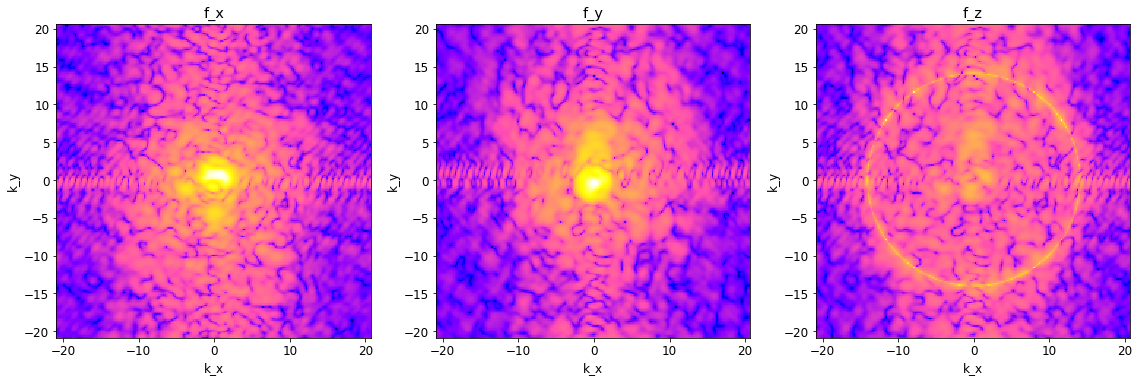

In [7]:
FourierSpace=nf.NFtoFourier(EW_Complex,NS_Complex,k_X_Rectangular,k_Y_Rectangular,k0,plotFourier=True)

In [8]:
print(k_X_Rectangular.shape)
print(FourierSpace[0].shape)
print(EW_Complex.shape)

(216,)
(216, 216)
(54, 54)


<ipython-input-9-542b8c2fe208>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(k_X_Rectangular,k_Y_Rectangular,FourierSpace[0].real,cmap='gnuplot2')


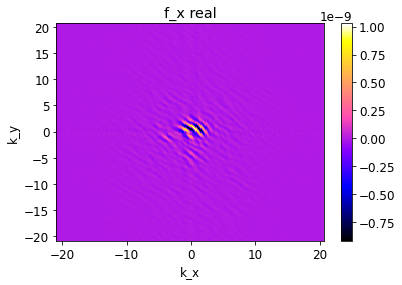

<ipython-input-9-542b8c2fe208>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(k_X_Rectangular,k_Y_Rectangular,FourierSpace[0].imag,cmap='gnuplot2')


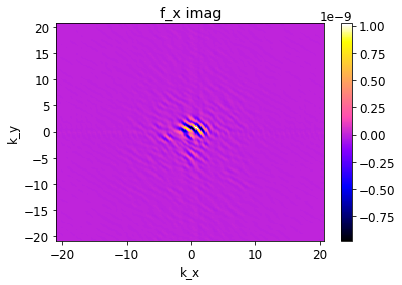

<ipython-input-9-542b8c2fe208>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(k_X_Rectangular,k_Y_Rectangular,FourierSpace[1].real,cmap='gnuplot2')


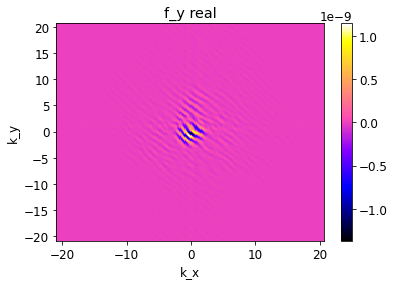

<ipython-input-9-542b8c2fe208>:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(k_X_Rectangular,k_Y_Rectangular,FourierSpace[1].imag,cmap='gnuplot2')


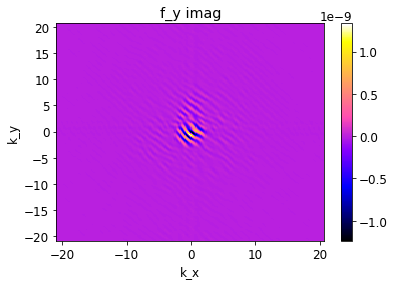

In [9]:
plt.pcolormesh(k_X_Rectangular,k_Y_Rectangular,FourierSpace[0].real,cmap='gnuplot2')
plt.title('f_x real')
plt.xlabel('k_x')
plt.ylabel('k_y')
plt.colorbar()
plt.show()

plt.pcolormesh(k_X_Rectangular,k_Y_Rectangular,FourierSpace[0].imag,cmap='gnuplot2')
plt.title('f_x imag')
plt.xlabel('k_x')
plt.ylabel('k_y')
plt.colorbar()
plt.show()

plt.pcolormesh(k_X_Rectangular,k_Y_Rectangular,FourierSpace[1].real,cmap='gnuplot2')
plt.title('f_y real')
plt.xlabel('k_x')
plt.ylabel('k_y')
plt.colorbar()
plt.show()

plt.pcolormesh(k_X_Rectangular,k_Y_Rectangular,FourierSpace[1].imag,cmap='gnuplot2')
plt.title('f_y imag')
plt.xlabel('k_x')
plt.ylabel('k_y')
plt.colorbar()
plt.show()


In [10]:
print(theta.shape)
print(FourierSpace[0].shape)
print(k_X_Rectangular.shape)

(630, 159)
(216, 216)
(216,)


<ipython-input-12-456e5e768912>:36: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm=ax.pcolormesh(theta,phi,20*np.log10(np.abs(Etheta)),cmap='gnuplot2')
<ipython-input-12-456e5e768912>:43: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm=ax.pcolormesh(theta,phi,20*np.log10(np.abs(Ephi)),cmap='gnuplot2')


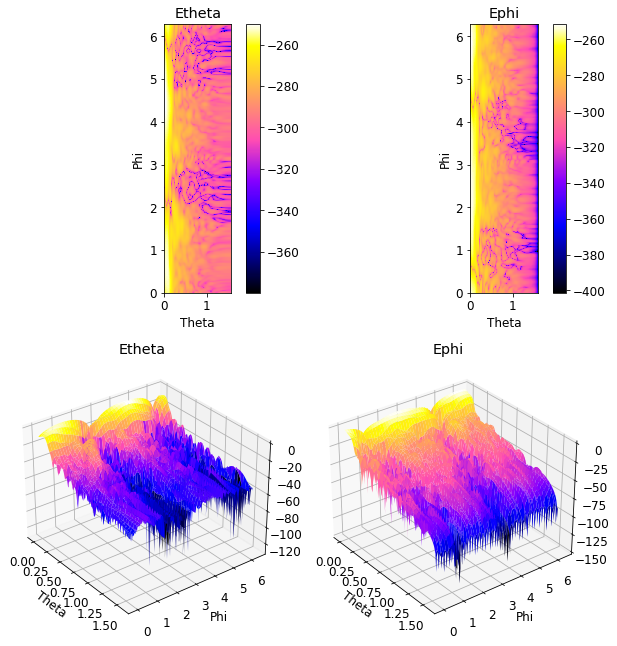

In [12]:
def FouriertoFF(f_x,f_y,f_z,theta,phi,k_x,k_y,k0,FFOutputs=False):

    '''Brings data from plave wave spectrum to the far-field pattern, by first inteprolating the data into
    spherical, then applying transformation.
    Returns list with [Etheta,Ephi]
    Input parameters:
    f_x, f_y, f_z: plane wave spectrum in x, y, z polarizations
    theta: vector of theta values for spherical coordinates
    phi: vector of phi values for spherical coordinates
    k_x and k_y: spectral frequency vector components
    k0: wave number (2pi/lambda0)
    plotFourier: if True, plots final FF pattern'''

    # try to update so that the definition of E uses k instead of k0
    
    
    xx = k0*np.sin(theta)*np.cos(phi)
    yy = k0*np.sin(theta)*np.sin(phi)

    f_x_interp = RectBivariateSpline(k_x,k_y,np.abs(f_x.T))
    f_y_interp = RectBivariateSpline(k_x,k_y,np.abs(f_y.T))
    f_z_interp = RectBivariateSpline(k_x,k_y,np.abs(f_z.T))

    f_X_Spherical = f_x_interp.ev(xx,yy)
    f_Y_Spherical = f_y_interp.ev(xx,yy)
    f_Z_Spherical = f_z_interp.ev(xx,yy)

    r=10000;
    C=1.0j*(k0*np.exp(-1.0j*k0*r))/(2*np.pi*r)
    Etheta=C*(f_X_Spherical*np.cos(phi)+f_Y_Spherical*np.sin(phi));
    Ephi=C*np.cos(theta)*(-f_X_Spherical*np.sin(phi)+f_Y_Spherical*np.cos(phi));

    if FFOutputs==True:
        fig=figure(figsize=(9,9))
        ax=fig.add_subplot(2,2,1)
        pcm=ax.pcolormesh(theta,phi,20*np.log10(np.abs(Etheta)),cmap='gnuplot2')
        ax.set_aspect('equal')
        ax.set_title('Etheta')
        ax.set_xlabel('Theta')
        ax.set_ylabel('Phi')
        colorbar(mappable=pcm,ax=ax)
        ax=fig.add_subplot(2,2,2)
        pcm=ax.pcolormesh(theta,phi,20*np.log10(np.abs(Ephi)),cmap='gnuplot2')
        ax.set_aspect('equal')
        ax.set_title('Ephi')
        ax.set_xlabel('Theta')
        ax.set_ylabel('Phi')
        colorbar(mappable=pcm,ax=ax)
        ax=fig.add_subplot(2,2,3,projection='3d')
        ax.plot_surface(theta,phi,20.0*np.log10(np.abs(Etheta))-np.nanmax(20.0*np.log10(np.abs(Etheta.T.conj()))),cmap='gnuplot2')
        ax.view_init(30,-37.5)
        ax.set_title('Etheta')
        ax.set_xlabel('Theta')
        ax.set_ylabel('Phi')
        ax=fig.add_subplot(2,2,4,projection='3d')
        ax.plot_surface(theta,phi,20.0*np.log10(np.abs(Ephi))-np.nanmax(20.0*np.log10(np.abs(Ephi.T.conj()))),cmap='gnuplot2')
        ax.view_init(30,-37.5)
        ax.set_title('Ephi')
        ax.set_xlabel('Theta')
        ax.set_ylabel('Phi')
        fig.tight_layout()

    return [Etheta,Ephi]



[Etheta,Ephi]=FouriertoFF(FourierSpace[0],FourierSpace[1],FourierSpace[2],
                             theta,phi,k_X_Rectangular,k_Y_Rectangular,k0,FFOutputs=True)

<ipython-input-13-1033316e00bc>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(theta,phi,Etheta.real,cmap='gnuplot2')


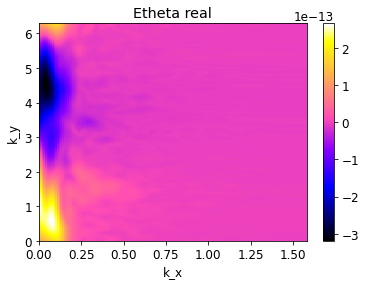

<ipython-input-13-1033316e00bc>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(theta,phi,Etheta.imag,cmap='gnuplot2')


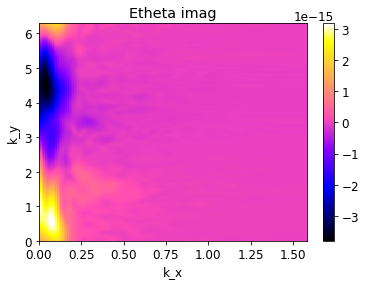

<ipython-input-13-1033316e00bc>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(theta,phi,Ephi.real,cmap='gnuplot2')


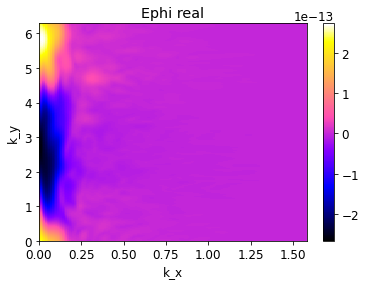

<ipython-input-13-1033316e00bc>:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(theta,phi,Ephi.imag,cmap='gnuplot2')


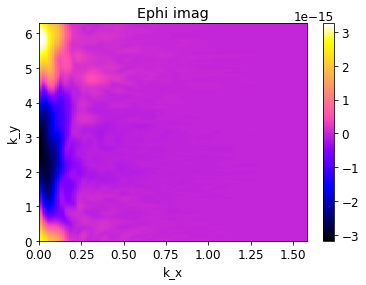

In [13]:
plt.pcolormesh(theta,phi,Etheta.real,cmap='gnuplot2')
plt.title('Etheta real')
plt.xlabel('k_x')
plt.ylabel('k_y')
plt.colorbar()
plt.show()

plt.pcolormesh(theta,phi,Etheta.imag,cmap='gnuplot2')
plt.title('Etheta imag')
plt.xlabel('k_x')
plt.ylabel('k_y')
plt.colorbar()
plt.show()

plt.pcolormesh(theta,phi,Ephi.real,cmap='gnuplot2')
plt.title('Ephi real')
plt.xlabel('k_x')
plt.ylabel('k_y')
plt.colorbar()
plt.show()

plt.pcolormesh(theta,phi,Ephi.imag,cmap='gnuplot2')
plt.title('Ephi imag')
plt.xlabel('k_x')
plt.ylabel('k_y')
plt.colorbar()
plt.show()

<ipython-input-14-032686cdfeba>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im=ax.pcolormesh(phi,theta,20*np.log10((1/norm)*np.abs(Etheta)),cmap='magma',vmin=-30)
<ipython-input-14-032686cdfeba>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im=ax.pcolormesh(phi,theta,20*np.log10((1/norm)*np.abs(Ephi)),cmap='magma',vmin=-30)
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling ba

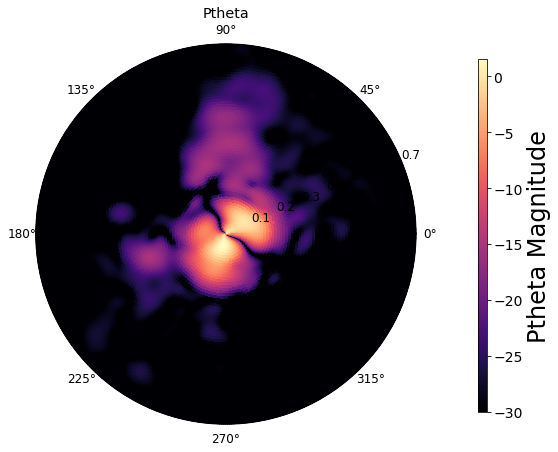

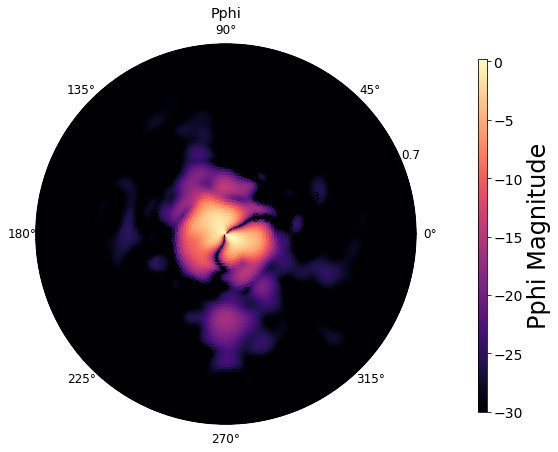

In [14]:
fig, ax = plt.subplots(figsize=(8,7),subplot_kw=dict(projection='polar'))
norm = max(np.abs(Etheta[:,0]))
im=ax.pcolormesh(phi,theta,20*np.log10((1/norm)*np.abs(Etheta)),cmap='magma',vmin=-30)
ax.set_ylim(0,0.7)
ax.set_title('Ptheta')
cbar_ax = fig.add_axes([0.95, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=14) 
cbar.set_label("Ptheta Magnitude",fontsize=24)

fig, ax = plt.subplots(figsize=(8,7),subplot_kw=dict(projection='polar'))
norm = max(np.abs(Ephi[:,0]))
im=ax.pcolormesh(phi,theta,20*np.log10((1/norm)*np.abs(Ephi)),cmap='magma',vmin=-30)
ax.set_ylim(0,0.7)
ax.set_title('Pphi')
cbar_ax = fig.add_axes([0.95, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=14) 
cbar.set_label("Pphi Magnitude",fontsize=24)



<ipython-input-34-636c7cbc616f>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im=ax.pcolormesh(phi,theta,20*np.log10((1/norm)*U_co),cmap='magma',vmin=-30)
<ipython-input-34-636c7cbc616f>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im=ax.pcolormesh(phi,theta,20*np.log10((1/norm)*U_cross),cmap='magma',vmin=-30)


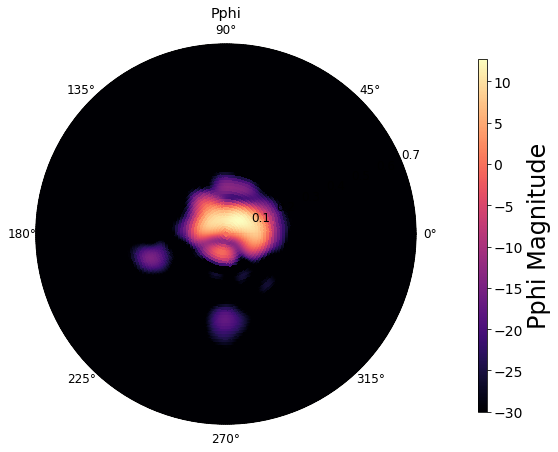

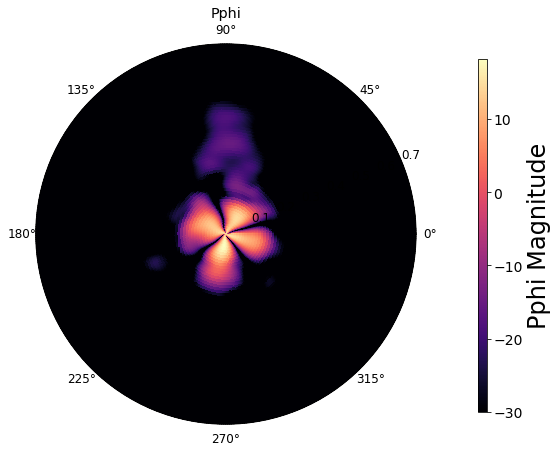

In [34]:
# Not sure what these are, but computing them

U_co = (np.abs(Etheta * np.cos(phi) - Ephi * np.sin(phi)))**2
U_cross = (np.abs(Etheta * np.sin(phi) - Ephi * np.cos(phi)))**2

fig, ax = plt.subplots(figsize=(8,7),subplot_kw=dict(projection='polar'))
norm = max(np.abs(U_co[:,0]))
im=ax.pcolormesh(phi,theta,20*np.log10((1/norm)*U_co),cmap='magma',vmin=-30)
ax.set_ylim(0,0.7)
ax.set_title('Pphi')
cbar_ax = fig.add_axes([0.95, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=14) 
cbar.set_label("Pphi Magnitude",fontsize=24)

fig, ax = plt.subplots(figsize=(8,7),subplot_kw=dict(projection='polar'))
im=ax.pcolormesh(phi,theta,20*np.log10((1/norm)*U_cross),cmap='magma',vmin=-30)
ax.set_ylim(0,0.7)
ax.set_title('Pphi')
cbar_ax = fig.add_axes([0.95, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=14) 
cbar.set_label("Pphi Magnitude",fontsize=24)

(630, 159)


<ipython-input-37-eb88215c71c5>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im=ax.pcolormesh(phi,theta,20*np.log10((1/norm)*W),cmap='magma',vmin=-30)


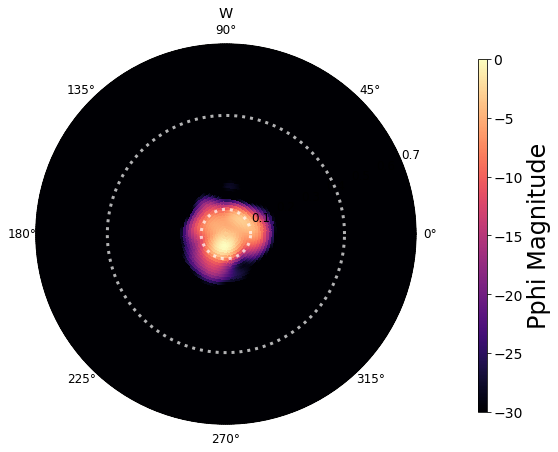

In [37]:
# Computing E and H plane


FWHMexp = 0.5*1.22*wl/3.0

thetas = np.arange(0,2*np.pi,0.01)
phis1 = FWHMexp*np.ones(len(thetas))
phis2 = np.radians(25)*np.ones(len(thetas))


print(Ephi.shape)
(Ephi*np.conjugate(Ephi))
W = (1/(2*np.pi*120))*abs((Ephi*np.conjugate(Ephi) + Etheta*np.conjugate(Etheta)))

fig, ax = plt.subplots(figsize=(8,7),subplot_kw=dict(projection='polar'))
norm = max(np.abs(W.flatten()))
im=ax.pcolormesh(phi,theta,20*np.log10((1/norm)*W),cmap='magma',vmin=-30)
ax.plot(thetas,phis1,color='white',alpha=0.7,linestyle=':',linewidth=3)
ax.plot(thetas,phis2,color='white',alpha=0.7,linestyle=':',linewidth=3)
ax.set_ylim(0,0.7)
ax.set_title('W')
cbar_ax = fig.add_axes([0.95, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=14) 
cbar.set_label("Pphi Magnitude",fontsize=24)